In [23]:
import pandas as pd
file_path = "/content/Data Analytics Assignment.xlsx"

sheet_names = ["Valid 1", "Valid 2", "Valid 3", "Invalid 1", "Invalid 2", "Invalid 3"]
combined_data = pd.concat(
    [pd.read_excel(file_path, sheet_name=sheet).assign(App_Name=sheet) for sheet in sheet_names],
    ignore_index=True
)

combined_data["IVT_Label"] = combined_data["App_Name"].apply(
    lambda x: "Non-IVT" if x.lower().startswith("valid") else "IVT"
)


print("Combined data shape:", combined_data.shape)
print(combined_data[["App_Name", "IVT_Label"]].drop_duplicates())

combined_data.to_csv("all_apps_combined.csv", index=False)

Combined data shape: (606, 14)
      App_Name IVT_Label
0      Valid 1   Non-IVT
101    Valid 2   Non-IVT
202    Valid 3   Non-IVT
303  Invalid 1       IVT
404  Invalid 2       IVT
505  Invalid 3       IVT


In [24]:
import numpy as np

def normalize_block(df_block):
    """Cleans each section (Total, Daily, Hourly)."""
    if df_block.shape[0] == 0:
        return pd.DataFrame()

    header_row = df_block.iloc[0].astype(str).tolist()
    df = df_block.copy().reset_index(drop=True)
    df.columns = header_row
    df = df.iloc[1:].reset_index(drop=True)

    df = df.dropna(how="all")
    df.columns = [str(c).strip() for c in df.columns]

    date_cols = [c for c in df.columns if 'date' in c.lower() or 'hour' in c.lower()]
    for col in df.columns:
        if col not in date_cols:
            df[col] = pd.to_numeric(df[col].replace('', np.nan), errors='coerce')

    for c in date_cols:
        try:
            df[c] = pd.to_datetime(df[c], errors='coerce')
        except:
            pass

    return df


def split_sheet_blocks(df_sheet):
    # """Separates Total, Daily, and Hourly data from a single sheet."""
    second_col = df_sheet.iloc[:, 1].astype(str).fillna('')
    idx_total_label = list(second_col[second_col.str.strip() == "Total Data"].index)
    idx_daily_label = list(second_col[second_col.str.strip() == "Daily Data"].index)
    idx_hourly_label = list(second_col[second_col.str.strip() == "Hourly Data"].index)

    total_block, daily_block, hourly_block = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    try:
        if len(idx_total_label) > 0 and len(idx_daily_label) > 0:
            total_block = df_sheet.iloc[idx_total_label[0] + 1:idx_daily_label[0]].reset_index(drop=True)

        if len(idx_daily_label) > 0:

            daily_start = idx_daily_label[0] + 1
            daily_end = idx_hourly_label[0] if len(idx_hourly_label) > 0 else len(df_sheet)
            daily_block = df_sheet.iloc[daily_start:daily_end].reset_index(drop=True)

        if len(idx_hourly_label) > 0:

            hourly_start = idx_hourly_label[0] + 1
            hourly_block = df_sheet.iloc[hourly_start:].reset_index(drop=True)
    except Exception as e:
        print(" Error splitting:", e)

    return total_block, daily_block, hourly_block

In [25]:
all_total = []
all_daily = []
all_hourly = []


for sheet in ["Valid 1", "Valid 2", "Valid 3", "Invalid 1", "Invalid 2", "Invalid 3"]:
    print(f" Processing sheet: {sheet}")
    df_sheet = pd.read_excel("/content/Data Analytics Assignment.xlsx", sheet_name=sheet, header=None, dtype=object)

    total_block, daily_block, hourly_block = split_sheet_blocks(df_sheet)

    total_df = normalize_block(total_block)
    daily_df = normalize_block(daily_block)
    hourly_df = normalize_block(hourly_block)

    print(f"  Total block shape: {total_block.shape}")
    print(f"  Normalized total shape: {total_df.shape}")
    print(f"  Daily block shape: {daily_block.shape}")
    print(f"  Normalized daily shape: {daily_df.shape}")
    print(f"  Hourly block shape: {hourly_block.shape}")
    print(f"---")



    ivt_status = "Non-IVT" if sheet.lower().startswith("valid") else "IVT"

    for df_out, container in [(total_df, all_total), (daily_df, all_daily), (hourly_df, all_hourly)]:
        if df_out.shape[0] > 0:
            df_out["App_Name"] = sheet
            df_out["IVT_Label"] = ivt_status
            container.append(df_out)

 Processing sheet: Valid 1
  Total block shape: (4, 12)
  Normalized total shape: (1, 12)
  Daily block shape: (8, 12)
  Normalized daily shape: (5, 12)
  Hourly block shape: (85, 12)
---
 Processing sheet: Valid 2
  Total block shape: (4, 12)
  Normalized total shape: (1, 12)
  Daily block shape: (8, 12)
  Normalized daily shape: (5, 12)
  Hourly block shape: (85, 12)
---
 Processing sheet: Valid 3
  Total block shape: (4, 12)
  Normalized total shape: (1, 12)
  Daily block shape: (8, 12)
  Normalized daily shape: (5, 12)
  Hourly block shape: (85, 12)
---
 Processing sheet: Invalid 1
  Total block shape: (4, 12)
  Normalized total shape: (1, 12)
  Daily block shape: (8, 12)
  Normalized daily shape: (5, 12)
  Hourly block shape: (85, 12)
---
 Processing sheet: Invalid 2
  Total block shape: (4, 12)
  Normalized total shape: (1, 12)
  Daily block shape: (8, 12)
  Normalized daily shape: (5, 12)
  Hourly block shape: (85, 12)
---
 Processing sheet: Invalid 3
  Total block shape: (4, 12

In [26]:

master_total = pd.concat(all_total, ignore_index=True)
master_daily = pd.concat(all_daily, ignore_index=True)
master_hourly = pd.concat(all_hourly, ignore_index=True)


master_total.to_csv("master_total.csv", index=False)
master_daily.to_csv("master_daily.csv", index=False)
master_hourly.to_csv("master_hourly.csv", index=False)

print("All done!")
print("Total rows:", len(master_total))
print("Daily rows:", len(master_daily))
print("Hourly rows:", len(master_hourly))


All done!
Total rows: 6
Daily rows: 30
Hourly rows: 504


In [27]:
# Combine all apps’ sections
master_total = pd.concat(all_total, ignore_index=True)
master_daily = pd.concat(all_daily, ignore_index=True)
master_hourly = pd.concat(all_hourly, ignore_index=True)

# Save results
master_total.to_csv("master_total.csv", index=False)
master_daily.to_csv("master_daily.csv", index=False)
master_hourly.to_csv("master_hourly.csv", index=False)

print("All done!")
print("Total rows:", len(master_total))
print("Daily rows:", len(master_daily))
print("Hourly rows:", len(master_hourly))

All done!
Total rows: 6
Daily rows: 30
Hourly rows: 504


In [28]:
all_total = []
all_daily = []
all_hourly = []


for sheet in ["Valid 1", "Valid 2", "Valid 3", "Invalid 1", "Invalid 2", "Invalid 3"]:
    print(f" Processing sheet: {sheet}")
    df_sheet = pd.read_excel("/content/Data Analytics Assignment.xlsx", sheet_name=sheet, header=None, dtype=object)

    total_block, daily_block, hourly_block = split_sheet_blocks(df_sheet)

    total_df = normalize_block(total_block)
    daily_df = normalize_block(daily_block)
    hourly_df = normalize_block(hourly_block)

    print(f"  Total block shape: {total_block.shape}")
    print(f"  Normalized total shape: {total_df.shape}")
    print(f"  Daily block shape: {daily_df.shape}")
    print(f"  Normalized daily shape: {daily_df.shape}")
    print(f"  Hourly block shape: {hourly_block.shape}")
    print(f"---")


    ivt_status = "Non-IVT" if sheet.lower().startswith("valid") else "IVT"

    for df_out, container in [(total_df, all_total), (daily_df, all_daily), (hourly_df, all_hourly)]:
        if df_out.shape[0] > 0:
            df_out["App_Name"] = sheet
            df_out["IVT_Label"] = ivt_status
            container.append(df_out)

 Processing sheet: Valid 1
  Total block shape: (4, 12)
  Normalized total shape: (1, 12)
  Daily block shape: (5, 12)
  Normalized daily shape: (5, 12)
  Hourly block shape: (85, 12)
---
 Processing sheet: Valid 2
  Total block shape: (4, 12)
  Normalized total shape: (1, 12)
  Daily block shape: (5, 12)
  Normalized daily shape: (5, 12)
  Hourly block shape: (85, 12)
---
 Processing sheet: Valid 3
  Total block shape: (4, 12)
  Normalized total shape: (1, 12)
  Daily block shape: (5, 12)
  Normalized daily shape: (5, 12)
  Hourly block shape: (85, 12)
---
 Processing sheet: Invalid 1
  Total block shape: (4, 12)
  Normalized total shape: (1, 12)
  Daily block shape: (5, 12)
  Normalized daily shape: (5, 12)
  Hourly block shape: (85, 12)
---
 Processing sheet: Invalid 2
  Total block shape: (4, 12)
  Normalized total shape: (1, 12)
  Daily block shape: (5, 12)
  Normalized daily shape: (5, 12)
  Hourly block shape: (85, 12)
---
 Processing sheet: Invalid 3
  Total block shape: (4, 12

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Loading combined daily data
df = pd.read_csv("master_daily.csv")

# Check columns and structure
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head(3))


Shape: (30, 14)
Columns: ['nan', 'Date', 'unique_idfas', 'unique_ips', 'unique_uas', 'total_requests', 'requests_per_idfa', 'impressions', 'impressions_per_idfa', 'idfa_ip_ratio', 'idfa_ua_ratio', 'IVT', 'App_Name', 'IVT_Label']
   nan        Date  unique_idfas  unique_ips  unique_uas  total_requests  \
0  NaN  2025-09-11         93345       93340          22           99280   
1  NaN  2025-09-12        515646      515307          25          649515   
2  NaN  2025-09-13        406993      406729          25          473346   

   requests_per_idfa  impressions  impressions_per_idfa  idfa_ip_ratio  \
0           1.063581            0                     0       1.000054   
1           1.259614            0                     0       1.000658   
2           1.163032            0                     0       1.000649   

   idfa_ua_ratio       IVT App_Name IVT_Label  
0    4242.954545  0.003456  Valid 1   Non-IVT  
1   20625.840000  0.003409  Valid 1   Non-IVT  
2   16279.720000  0.00603

In [30]:
%pip install pandasql

In [31]:
from pandasql import sqldf
query = """
SELECT *
FROM master_daily
WHERE IVT_Label = 'IVT'
LIMIT 10;
"""
result_df = sqldf(query, globals())
display(result_df)

,nan,Date,unique_idfas,unique_ips,unique_uas,total_requests,requests_per_idfa,impressions,impressions_per_idfa,idfa_ip_ratio,idfa_ua_ratio,IVT,App_Name,IVT_Label
0,None,2025-09-11 00:00:00.000000,91848,91830,232,97817,1.064988,0,0,1.000196,395.896552,0.003532,Invalid 1,IVT
1,None,2025-09-12 00:00:00.000000,376599,376351,268,480852,1.276828,0,0,1.000659,1405.220149,0.778107,Invalid 1,IVT
2,None,2025-09-13 00:00:00.000000,225317,225179,260,261039,1.158541,0,0,1.000613,866.603846,0.994060,Invalid 1,IVT
3,None,2025-09-14 00:00:00.000000,238368,238209,267,280450,1.176542,0,0,1.000667,892.764045,0.999405,Invalid 1,IVT
4,None,2025-09-15 00:00:00.000000,55073,55062,222,60235,1.093730,0,0,1.000200,248.076577,1.000000,Invalid 1,IVT
5,None,2025-09-11 00:00:00.000000,26051,26049,774,27023,1.037311,0,0,1.000077,33.657623,0.274060,Invalid 2,IVT
6,None,2025-09-12 00:00:00.000000,162095,161975,1174,194185,1.197970,0,0,1.000741,138.070698,0.995055,Invalid 2,IVT
7,None,2025-09-13 00:00:00.000000,146191,146082,1171,165609,1.132826,0,0,1.000746,124.842869,0.997219,Invalid 2,IVT
8,None,2025-09-14 00:00:00.000000,150568,150428,1232,171836,1.141252,0,0,1.000931,122.214286,0.999106,Invalid 2,IVT
9,None,2025-09-15 00:00:00.000000,28822,28819,834,30555,1.060128,0,0,1.000104,34.558753,1.000000,Invalid 2,IVT


In [32]:
# Clean up date column name (some files may have spaces)
df.columns = [c.strip() for c in df.columns]

# Find the column that contains 'date'
date_col = [c for c in df.columns if 'date' in c.lower()][0]

# Convert to datetime
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

# Drop rows with no date
df = df.dropna(subset=[date_col])
print("Cleaned rows:", df.shape[0])


Cleaned rows: 30


In [33]:
metrics = ["requests_per_idfa", "idfa_ip_ratio", "idfa_ua_ratio", "impressions_per_idfa"]
summary = df.groupby("IVT_Label")[metrics].mean().round(2)
print("Average metrics by IVT status:")
print(summary)


Average metrics by IVT status:
           requests_per_idfa  idfa_ip_ratio  idfa_ua_ratio  \
IVT_Label                                                    
IVT                     1.17           1.00         495.48   
Non-IVT                 1.16           1.01        7455.29   

           impressions_per_idfa  
IVT_Label                        
IVT                         0.0  
Non-IVT                     0.0  


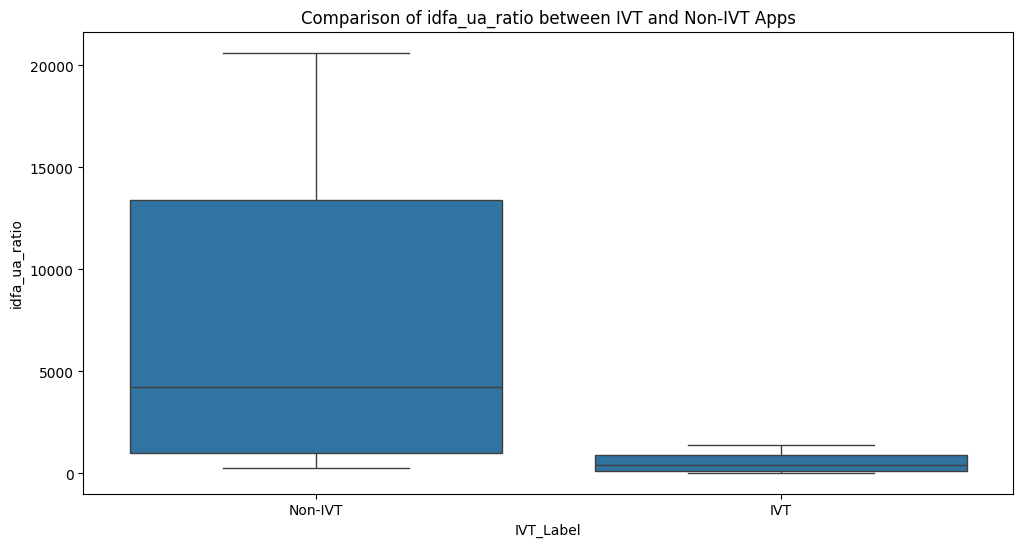

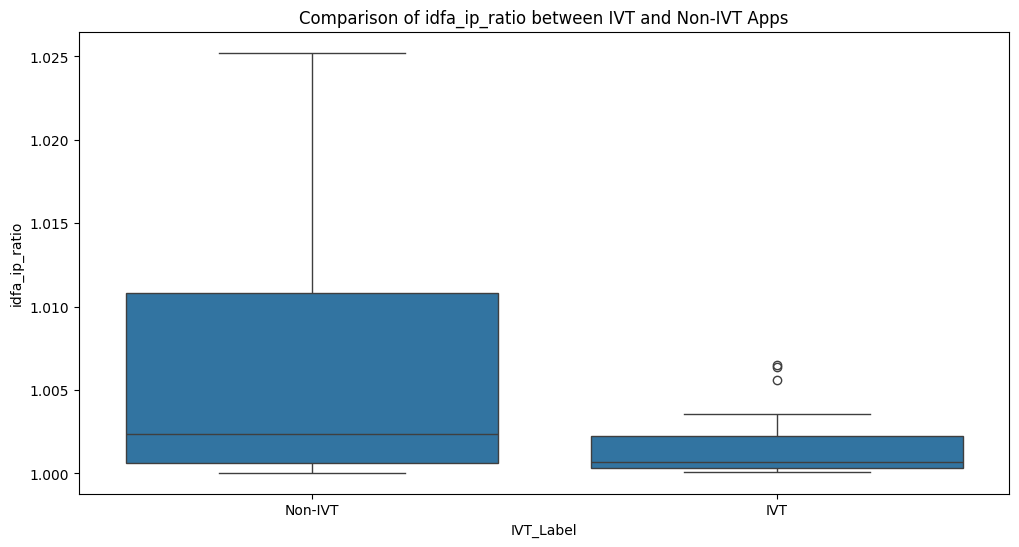

In [34]:
import seaborn as sns
plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="IVT_Label", y="idfa_ua_ratio")
plt.title("Comparison of idfa_ua_ratio between IVT and Non-IVT Apps")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="IVT_Label", y="idfa_ip_ratio")
plt.title("Comparison of idfa_ip_ratio between IVT and Non-IVT Apps")
plt.show()


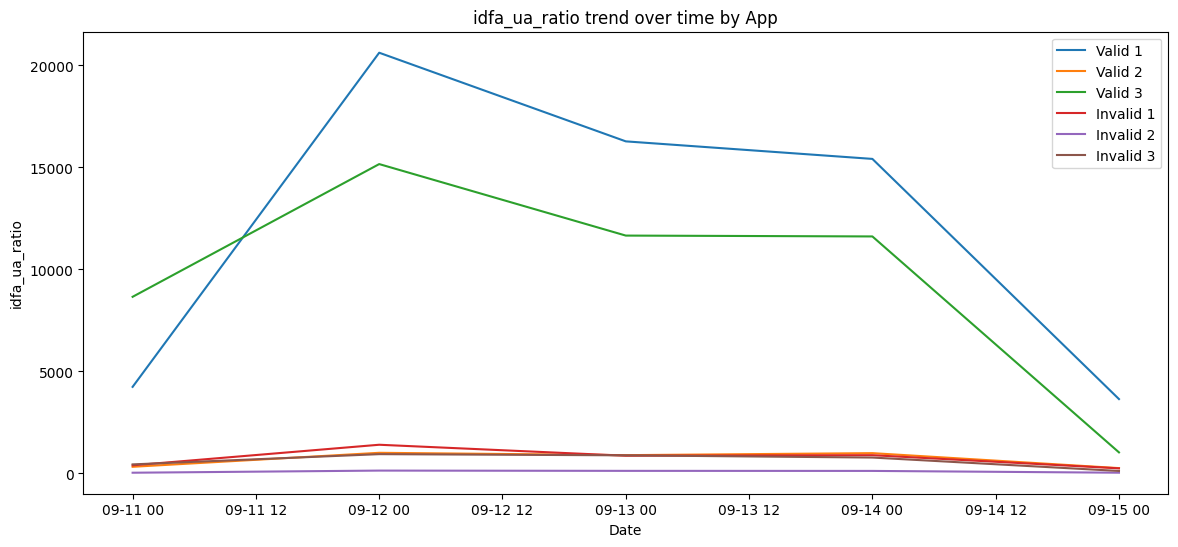

In [35]:
plt.figure(figsize=(14,6))
for app in df["App_Name"].unique():
    subset = df[df["App_Name"] == app]
    plt.plot(subset[date_col], subset["idfa_ua_ratio"], label=app)
plt.legend()
plt.title("idfa_ua_ratio trend over time by App")
plt.xlabel("Date")
plt.ylabel("idfa_ua_ratio")
plt.show()


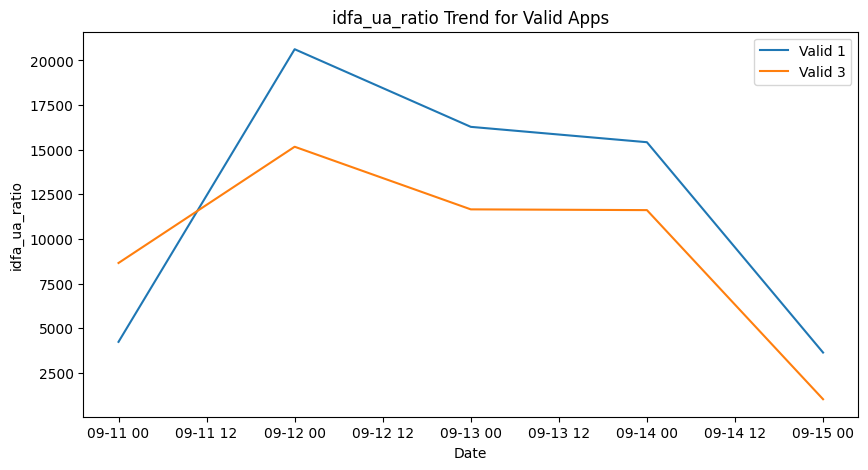

In [36]:
plt.figure(figsize=(10,5))
for app in ['Valid 1', 'Valid 3']:  # replace with actual app names
    subset = df[df['App_Name'] == app]
    plt.plot(subset['Date'], subset['idfa_ua_ratio'], label=app)

plt.title('idfa_ua_ratio Trend for Valid Apps')
plt.xlabel('Date')
plt.ylabel('idfa_ua_ratio')
plt.legend()
plt.show()

In [37]:
import pandas as pd

# Read all CSV files
daily = pd.read_csv("master_daily.csv")
hourly = pd.read_csv("master_hourly.csv")
total = pd.read_csv("master_total.csv")


In [38]:
daily["Data_Type"] = "Daily"
hourly["Data_Type"] = "Hourly"
total["Data_Type"] = "Total"


In [39]:
combined_df = pd.concat([daily, hourly, total], ignore_index=True)


In [40]:
# Removing empty or "Total" rows
combined_df = combined_df.dropna(how='all')
combined_df = combined_df[~combined_df.apply(lambda x: x.astype(str).str.contains('Total', case=False)).any(axis=1)]

# Removing duplicate rows
combined_df = combined_df.drop_duplicates()

# Clean up column names
combined_df.columns = combined_df.columns.str.strip()


In [41]:
combined_df.to_csv("All_Apps_Cleaned.csv", index=False)
